In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_excel('dataset.xlsx', index_col=0)

In [3]:
df.head() #reading the first 5 rows of the data

,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
Patient ID,,,,,,,,,,,,,,,,,,,,,
44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Analysis of Dataset

### How many instances and features does the dataset have?

In [4]:
df.shape #checking the shape of the data to check total entries and features

(5644, 110)

In [5]:
df.dtypes # checking for the type of dataset, numerical, categorical , or mixed?

Patient age quantile                                       int64
SARS-Cov-2 exam result                                    object
Patient addmited to regular ward (1=yes, 0=no)             int64
Patient addmited to semi-intensive unit (1=yes, 0=no)      int64
Patient addmited to intensive care unit (1=yes, 0=no)      int64
                                                          ...   
HCO3 (arterial blood gas analysis)                       float64
pO2 (arterial blood gas analysis)                        float64
Arteiral Fio2                                            float64
Phosphor                                                 float64
ctO2 (arterial blood gas analysis)                       float64
Length: 110, dtype: object

In [6]:
df.isnull().sum().sum() # finding the total null values in the  data

551682

### The data set seems to be a mixed type , since some features are categorical, those features must be converted to numerical to ensure proper analysis and proper working of the model

In [7]:
numeric_cols=df.select_dtypes(include=np.number).columns.tolist() #extracting the numerical features

In [8]:
non_cols=df.drop(columns=numeric_cols) #seperating the non numerical features

In [9]:
non_cols.columns

Index(['SARS-Cov-2 exam result', 'Respiratory Syncytial Virus', 'Influenza A',
       'Influenza B', 'Parainfluenza 1', 'CoronavirusNL63',
       'Rhinovirus/Enterovirus', 'Coronavirus HKU1', 'Parainfluenza 3',
       'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4',
       'Coronavirus229E', 'CoronavirusOC43', 'Inf A H1N1 2009',
       'Bordetella pertussis', 'Metapneumovirus', 'Parainfluenza 2',
       'Influenza B, rapid test', 'Influenza A, rapid test', 'Strepto A',
       'Urine - Esterase', 'Urine - Aspect', 'Urine - pH',
       'Urine - Hemoglobin', 'Urine - Bile pigments', 'Urine - Ketone Bodies',
       'Urine - Nitrite', 'Urine - Urobilinogen', 'Urine - Protein',
       'Urine - Leukocytes', 'Urine - Crystals', 'Urine - Hyaline cylinders',
       'Urine - Granular cylinders', 'Urine - Yeasts', 'Urine - Color'],
      dtype='object')

In [10]:
for col in non_cols:
    print(col , ":",non_cols[col].unique()) #analyzing the unique entries of each categorical feature

SARS-Cov-2 exam result : ['negative' 'positive']
Respiratory Syncytial Virus : [nan 'not_detected' 'detected']
Influenza A : [nan 'not_detected' 'detected']
Influenza B : [nan 'not_detected' 'detected']
Parainfluenza 1 : [nan 'not_detected' 'detected']
CoronavirusNL63 : [nan 'not_detected' 'detected']
Rhinovirus/Enterovirus : [nan 'detected' 'not_detected']
Coronavirus HKU1 : [nan 'not_detected' 'detected']
Parainfluenza 3 : [nan 'not_detected' 'detected']
Chlamydophila pneumoniae : [nan 'not_detected' 'detected']
Adenovirus : [nan 'not_detected' 'detected']
Parainfluenza 4 : [nan 'not_detected' 'detected']
Coronavirus229E : [nan 'not_detected' 'detected']
CoronavirusOC43 : [nan 'not_detected' 'detected']
Inf A H1N1 2009 : [nan 'not_detected' 'detected']
Bordetella pertussis : [nan 'not_detected' 'detected']
Metapneumovirus : [nan 'not_detected' 'detected']
Parainfluenza 2 : [nan 'not_detected']
Influenza B, rapid test : [nan 'negative' 'positive']
Influenza A, rapid test : [nan 'negat

In [11]:
# the data has a lot of binary yes or no type features, which can be easily replaced by 1 and 0 
df.replace('not_detected', 0, inplace=True)
df.replace('detected', 1, inplace=True)
df.replace('negative', 0, inplace=True)
df.replace('positive', 1, inplace=True)
df.replace('absent', 0, inplace=True)
df.replace('present', 1, inplace=True)


In [12]:
#not done and Nao Realizado both need to replaced with nan
df.replace('not_done', np.nan, inplace=True)
df['Urine - pH'].replace('Não Realizado', np.nan, inplace=True)

In [13]:
#I am taking the assumption that normal means the abscence of something , and <1000 falls into the same range so it can be
#equated to 0 ,so these both equate to 0 based of previous reasoning
df.replace('normal', 0, inplace=True)
df.replace('<1000', '0', inplace=True)

In [14]:
#for both of these columns , the entries are as string but they should be float
df['Urine - pH'] = df['Urine - pH'].astype('float64')
df['Urine - Leukocytes'] = df['Urine - Leukocytes'].astype('float64')

In [15]:
#creating dictionary to replace other categorical features by suitable numbers
rep = {"Urine - Aspect":     {"clear": 0, "altered_coloring": 1 , "lightly_cloudy" : 2, "cloudy":3},
            "Urine - Crystals": {"Ausentes": 0, "Urato Amorfo --+": 1, "Oxalato de Cálcio -++": 2, "Urato Amorfo +++": 2,
                                  "Oxalato de Cálcio +++": 3 },
           "Urine - Color":     {"light_yellow":0,"citrus_yellow": 1 , "yellow" : 2, "orange":3},
          }

In [16]:
df=df.replace(rep)

In [17]:
#these features are not required for Task 1
df.drop(columns=['Patient addmited to regular ward (1=yes, 0=no)',
                      'Patient addmited to semi-intensive unit (1=yes, 0=no)',
                      'Patient addmited to intensive care unit (1=yes, 0=no)'], inplace=True)

In [18]:
#extracting the target variable and rest of the data
y=df['SARS-Cov-2 exam result']
X=df.drop(columns=['SARS-Cov-2 exam result'])

# Building a model and evaluating the results

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #splitting the data into testing and training

In [20]:
xgb_clsfr = XGBClassifier(max_depth= 7, n_estimators= 700, subsample = 1.0) # creating an XGB model with arbitrary parameters

In [21]:
xgb_clsfr.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=700, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [22]:
y_pred = xgb_clsfr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1536
           1       0.56      0.06      0.11       158

    accuracy                           0.91      1694
   macro avg       0.73      0.53      0.53      1694
weighted avg       0.88      0.91      0.87      1694



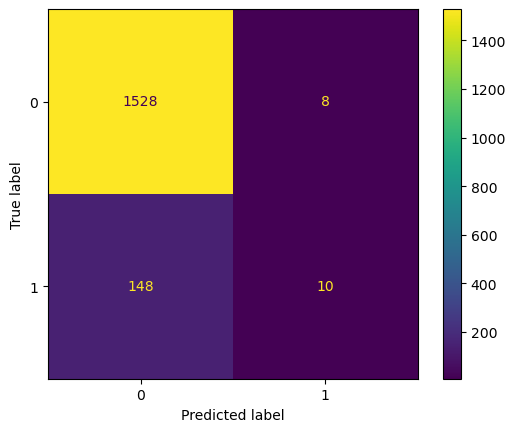

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# The model seems to predict the negative cases pretty well with high accuracy and recall, but the positive diagnosis is very poor with unacceptable accuracy and recall, and for medical diagnosis like this , correctly diagnosing positive cases is much more important than a few false positives. The recall and precision for positive cases should be higher. The data set might be imbalanced this causing bias towards the negative diagnosis, and there might also be null values

In [24]:
#Let's check if the dataset is balance

In [25]:
df['SARS-Cov-2 exam result'].value_counts()

0    5086
1     558
Name: SARS-Cov-2 exam result, dtype: int64

#The dataset is clearly imbalanced

In [32]:
#The positive cases and negative cases need to be seperated , because it is more important to correctly predict if a person
#has the disease as compared to a incorrectly diagnose COVID if the person does not have it, in medical diagnosis, false positive
#is less harmful than a false negative generally, so if we remove some entries to balance the data, it needs to be from negative 
#diagnosis since each true positive diagnosis is a lot more important

In [33]:
#splitting the data into negative diagnosis and postive diagnosis datasets
df_p = df[df['SARS-Cov-2 exam result'] == 1]
df_n = df[df['SARS-Cov-2 exam result'] == 0]


(-1.099999980088281,
 1.099999999051823,
 -1.0999997507192594,
 1.0999998249078344)

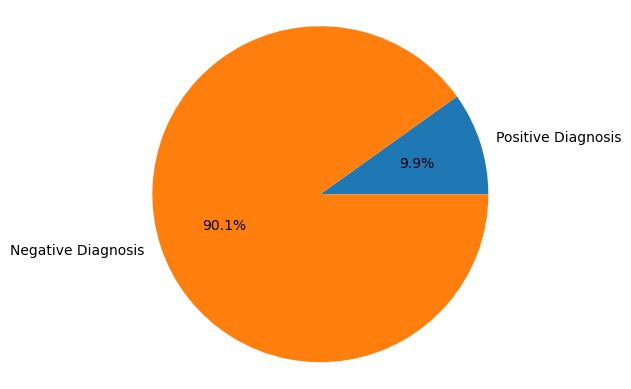

In [34]:
#plotting pie chart to depict the distribution of data 
fig1, ax1 = plt.subplots()
ax1.pie([len(df_p), len(df_n)], labels=['Positive Diagnosis', 'Negative Diagnosis'], autopct='%1.1f%%')
ax1.axis('equal') 

## The dataset has a lot of features, they should be checked for any null values, and since we don't want to remove any features that would only exist the small amound of positive cases, I want to check for the missing values that exist in those positive cases

In [35]:
for feature in df_p.columns:
    print(feature , ":" , df_p[feature].isna().sum())

Patient age quantile : 0
SARS-Cov-2 exam result : 0
Hematocrit : 475
Hemoglobin : 475
Platelets : 475
Mean platelet volume  : 477
Red blood Cells : 475
Lymphocytes : 475
Mean corpuscular hemoglobin concentration (MCHC) : 475
Leukocytes : 475
Basophils : 475
Mean corpuscular hemoglobin (MCH) : 475
Eosinophils : 475
Mean corpuscular volume (MCV) : 475
Monocytes : 475
Red blood cell distribution width (RDW) : 475
Serum Glucose : 525
Respiratory Syncytial Virus : 446
Influenza A : 446
Influenza B : 446
Parainfluenza 1 : 446
CoronavirusNL63 : 446
Rhinovirus/Enterovirus : 446
Mycoplasma pneumoniae : 558
Coronavirus HKU1 : 446
Parainfluenza 3 : 446
Chlamydophila pneumoniae : 446
Adenovirus : 446
Parainfluenza 4 : 446
Coronavirus229E : 446
CoronavirusOC43 : 446
Inf A H1N1 2009 : 446
Bordetella pertussis : 446
Metapneumovirus : 446
Parainfluenza 2 : 446
Neutrophils : 483
Urea : 499
Proteina C reativa mg/dL : 488
Creatinine : 496
Potassium : 500
Sodium : 500
Influenza B, rapid test : 496
Influen

In [36]:
# I am dropping the columns which have at least 95% negative nulls in the positive diagnosis 
to_drop= [feature for feature in df_p.columns if df_p[feature].isna().sum() >= 0.95*len(df_p)]    

In [37]:
to_drop

['Mycoplasma pneumoniae',
 'Ionized calcium\xa0',
 'Strepto A',
 'Magnesium',
 'pCO2 (venous blood gas analysis)',
 'Hb saturation (venous blood gas analysis)',
 'Base excess (venous blood gas analysis)',
 'pO2 (venous blood gas analysis)',
 'Fio2 (venous blood gas analysis)',
 'Total CO2 (venous blood gas analysis)',
 'pH (venous blood gas analysis)',
 'HCO3 (venous blood gas analysis)',
 'Rods #',
 'Segmented',
 'Promyelocytes',
 'Metamyelocytes',
 'Myelocytes',
 'Myeloblasts',
 'Urine - Esterase',
 'Urine - Aspect',
 'Urine - pH',
 'Urine - Hemoglobin',
 'Urine - Bile pigments',
 'Urine - Ketone Bodies',
 'Urine - Nitrite',
 'Urine - Density',
 'Urine - Urobilinogen',
 'Urine - Protein',
 'Urine - Sugar',
 'Urine - Leukocytes',
 'Urine - Crystals',
 'Urine - Red blood cells',
 'Urine - Hyaline cylinders',
 'Urine - Granular cylinders',
 'Urine - Yeasts',
 'Urine - Color',
 'Partial thromboplastin time\xa0(PTT)\xa0',
 'Relationship (Patient/Normal)',
 'International normalized ratio 

In [38]:
X=df.drop(columns=to_drop)

In [39]:
X.shape

(5644, 49)

# Now creating another model to see if that made a difference

In [40]:
y=X['SARS-Cov-2 exam result']
X1=X.drop(columns=['SARS-Cov-2 exam result'])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=42)

In [42]:
xgb_clsfr = XGBClassifier(max_depth= 7, n_estimators= 700, subsample = 1.0)

In [43]:
xgb_clsfr.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=700, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [44]:
y_pred = xgb_clsfr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1536
           1       0.61      0.07      0.12       158

    accuracy                           0.91      1694
   macro avg       0.76      0.53      0.54      1694
weighted avg       0.88      0.91      0.87      1694



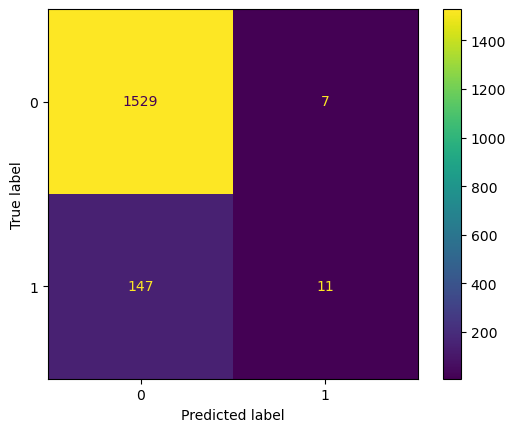

In [45]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## This model performs even worse, because we removed almost half of the columns , so it has less information to make connection between the features and the target

In [46]:
#splitting the dataset again , because I want to delete some of the negative rows with a lot of null values in order to bring
#the number of positive and negative cases closer
df_p = X[X['SARS-Cov-2 exam result'] == 1]
df_n = X[X['SARS-Cov-2 exam result'] == 0]

In [47]:
# I am checking for what amount of null values in a row , will the remaining cases be most closely distributed
for i in range(0,11):
    nas=15+i
    temp=df_n.dropna(axis=0,thresh=nas)
    leng=len(temp.index)
    print('Ratio of Positive to Negative Data for nulls per row,', nas ,' is :', (len(df_p.index))/leng)

Ratio of Positive to Negative Data for nulls per row, 15  is : 0.386159169550173
Ratio of Positive to Negative Data for nulls per row, 16  is : 0.386159169550173
Ratio of Positive to Negative Data for nulls per row, 17  is : 0.386159169550173
Ratio of Positive to Negative Data for nulls per row, 18  is : 0.3907563025210084
Ratio of Positive to Negative Data for nulls per row, 19  is : 0.39914163090128757
Ratio of Positive to Negative Data for nulls per row, 20  is : 0.9058441558441559
Ratio of Positive to Negative Data for nulls per row, 21  is : 0.9473684210526315
Ratio of Positive to Negative Data for nulls per row, 22  is : 1.3285714285714285
Ratio of Positive to Negative Data for nulls per row, 23  is : 1.381188118811881
Ratio of Positive to Negative Data for nulls per row, 24  is : 1.4381443298969072
Ratio of Positive to Negative Data for nulls per row, 25  is : 1.4919786096256684


### It seems like dropping rows with at least 21 nulls will result in the closest distribution of positive and negative cases


In [48]:
df_n = df_n.dropna(axis=0, thresh=21)

In [49]:
X = pd.concat([df_n, df_p])

(-1.0999998376446245,
 1.0999999922687915,
 -1.099999959428176,
 1.0999997651789921)

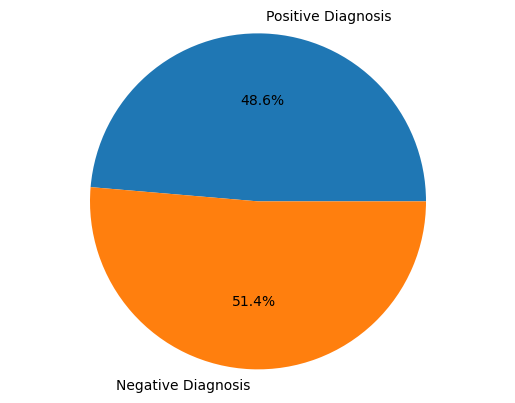

In [50]:
# checking for the distribution again
fig1, ax1 = plt.subplots()
ax1.pie([len(df_p), len(df_n)], labels=['Positive Diagnosis', 'Negative Diagnosis'], autopct='%1.1f%%')
ax1.axis('equal')

## Now that the dataset is balanced , let's analyse it a bit

In [51]:
X.describe()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,...,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Alanine transaminase,Aspartate transaminase,Gamma-glutamyltransferase,Total Bilirubin,Direct Bilirubin,Indirect Bilirubin,Alkaline phosphatase
count,1147.000000,1147.000000,511.000000,511.000000,511.000000,508.000000,511.000000,511.000000,511.000000,511.000000,...,368.000000,361.000000,361.000000,223.000000,224.000000,1.530000e+02,1.820000e+02,1.820000e+02,1.820000e+02,1.440000e+02
mean,10.048823,0.486486,-0.004733,-0.004316,-0.042645,0.000296,0.001777,-0.030424,0.001536,-0.007396,...,-0.001758,0.055402,0.058172,0.003780,0.003349,-1.479159e-09,-2.783733e-09,1.205602e-08,3.029357e-09,-2.037268e-09
std,5.672049,0.500035,1.037213,1.025965,1.010523,0.989167,1.035953,1.011963,0.970465,1.012194,...,1.003004,0.229080,0.234393,1.005901,1.006056,1.003284e+00,1.002759e+00,1.002759e+00,1.002759e+00,1.003490e+00
min,0.000000,0.000000,-4.501420,-4.345603,-2.552426,-2.345381,-3.970608,-1.865070,-4.535603,-2.020303,...,-5.246946,0.000000,0.000000,-0.641951,-0.704122,-4.766074e-01,-1.093174e+00,-1.169722e+00,-7.710338e-01,-9.590281e-01
25%,5.000000,0.000000,-0.530252,-0.586244,-0.661874,-0.774677,-0.567950,-0.756294,-0.552476,-0.658126,...,-0.575008,0.000000,0.000000,-0.448998,-0.433161,-3.755311e-01,-7.870851e-01,-5.864632e-01,-7.710338e-01,-6.088295e-01
50%,10.000000,0.000000,0.053407,0.040316,-0.165682,-0.101517,0.031483,-0.082499,-0.054585,-0.219836,...,0.143752,0.000000,0.000000,-0.283610,-0.258972,-2.856855e-01,-1.749078e-01,-3.204721e-03,-2.786543e-01,-3.576001e-01
75%,15.000000,1.000000,0.740064,0.729532,0.462408,0.683835,0.683806,0.540121,0.642463,0.463339,...,0.503132,0.000000,0.000000,0.102296,0.031344,-6.107152e-02,1.311808e-01,-3.204721e-03,2.137252e-01,5.350256e-02
max,19.000000,1.000000,2.662704,2.671868,9.532034,3.713052,3.645706,3.764100,3.331071,4.455255,...,4.096930,1.000000,1.000000,7.930663,7.231172,8.507952e+00,5.028599e+00,6.995896e+00,6.614658e+00,3.882848e+00


In [52]:
# checking for the top most correlated features
corr=X.corr().abs()['SARS-Cov-2 exam result'].sort_values(ascending=False) 
corr

SARS-Cov-2 exam result                              1.000000
Leukocytes                                          0.310961
Platelets                                           0.289292
Rhinovirus/Enterovirus                              0.226252
Eosinophils                                         0.207889
Monocytes                                           0.197581
Aspartate transaminase                              0.150097
Inf A H1N1 2009                                     0.146544
Indirect Bilirubin                                  0.141361
Gamma-glutamyltransferase                           0.132165
Red blood Cells                                     0.128330
Total Bilirubin                                     0.125322
Mean platelet volume                                0.121176
Hemoglobin                                          0.114530
Influenza A, rapid test                             0.113170
Alanine transaminase                                0.112019
Hematocrit              

In [53]:
#It seems as if two of those features do not seem to impact the target variable at all
X['Parainfluenza 2'].value_counts()

0.0    587
Name: Parainfluenza 2, dtype: int64

In [54]:
X['Bordetella pertussis'].value_counts()

0.0    587
Name: Bordetella pertussis, dtype: int64

In [55]:
#both those features only had singular values, so I am dropping them
X=X.drop(columns=['Parainfluenza 2'])
X=X.drop(columns=['Bordetella pertussis'])

## Visual Analysis of some feature and there relation with the target variable

C:\Users\maab9\AppData\Local\Temp\ipykernel_23528\3963527764.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


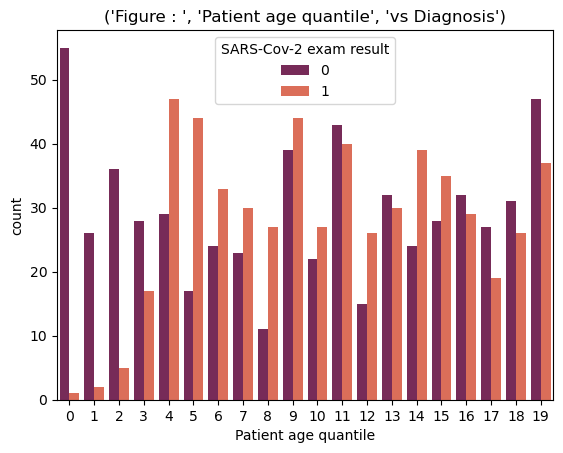

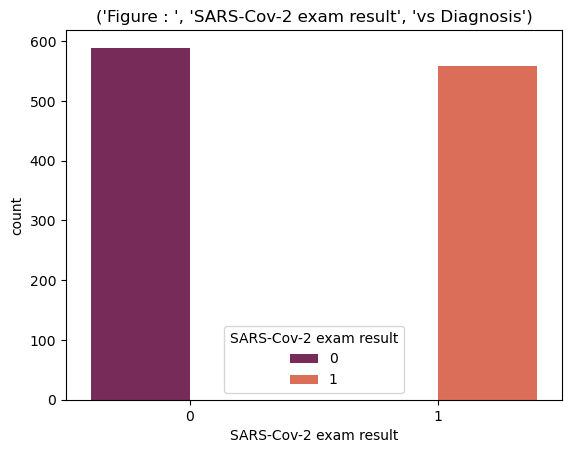

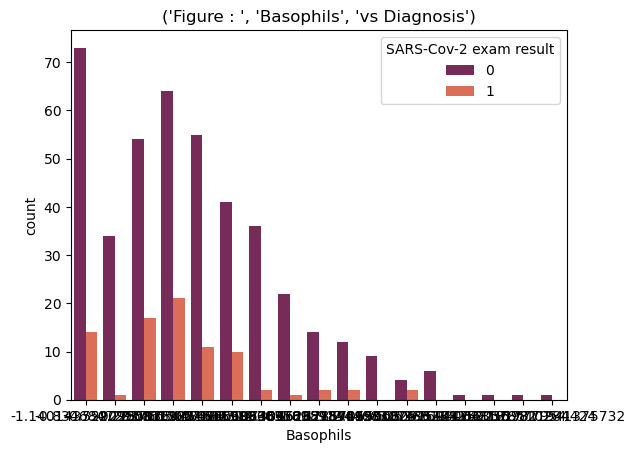

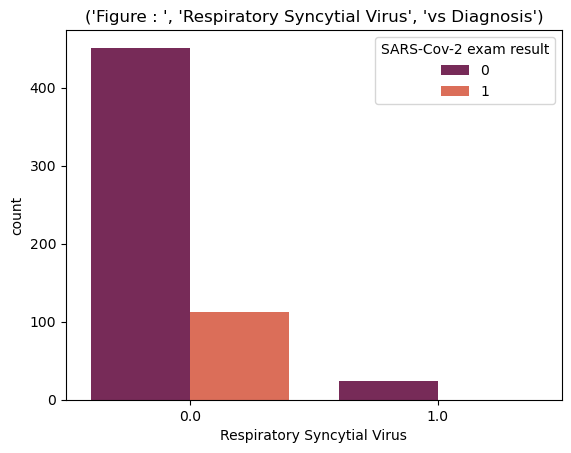

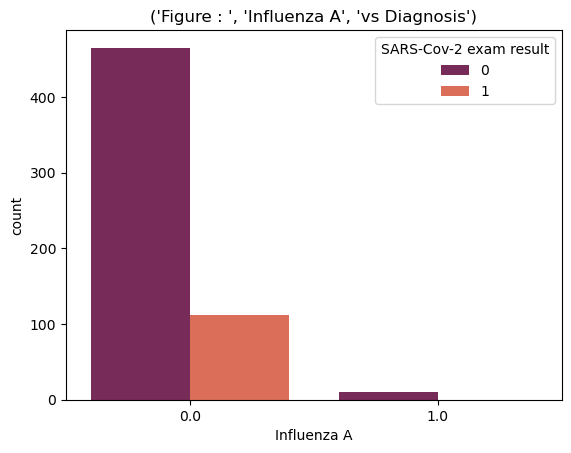

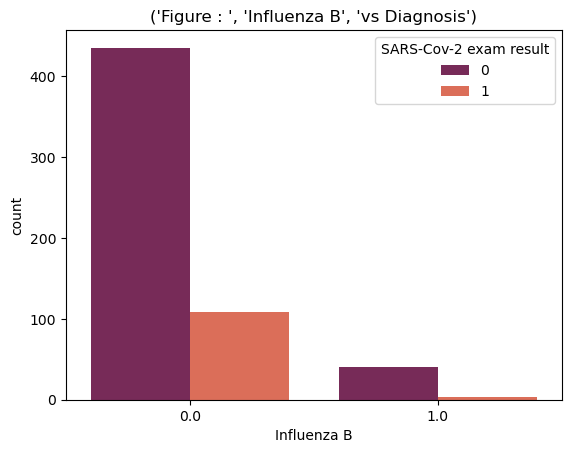

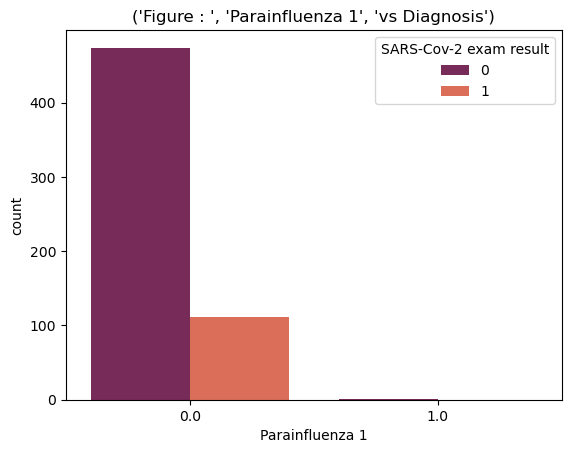

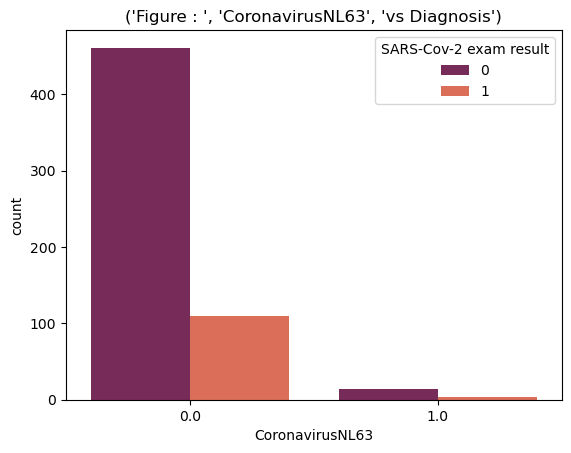

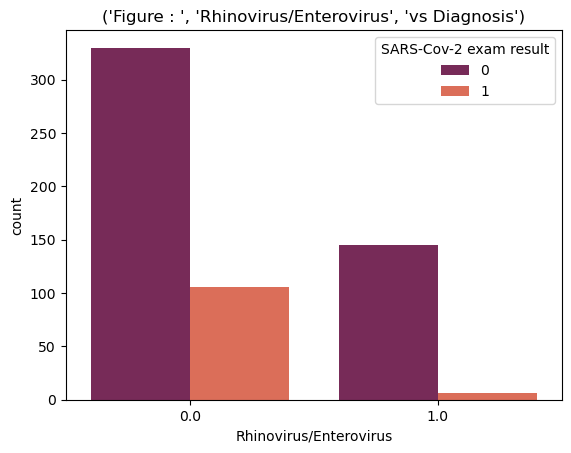

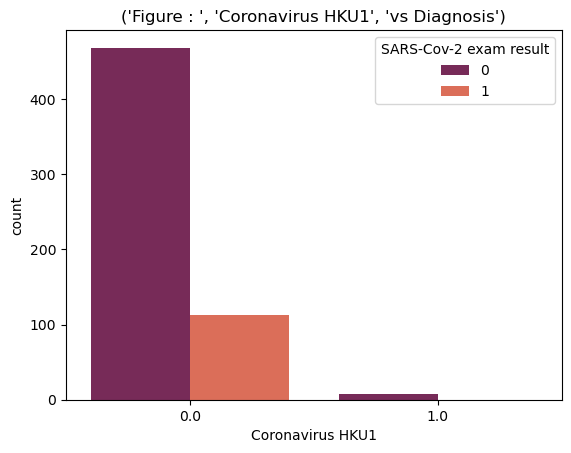

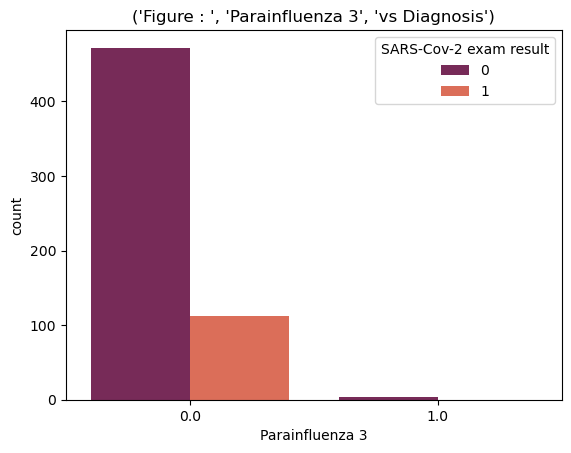

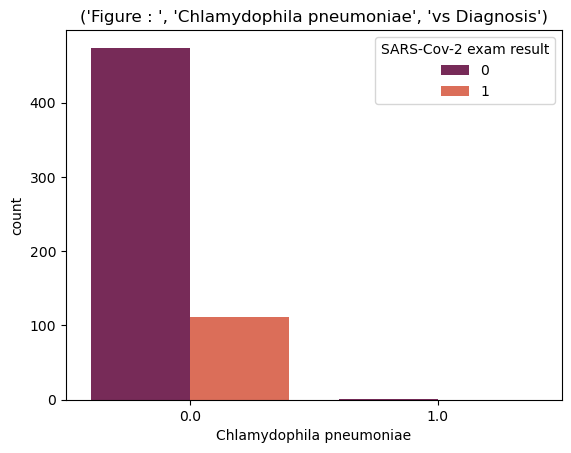

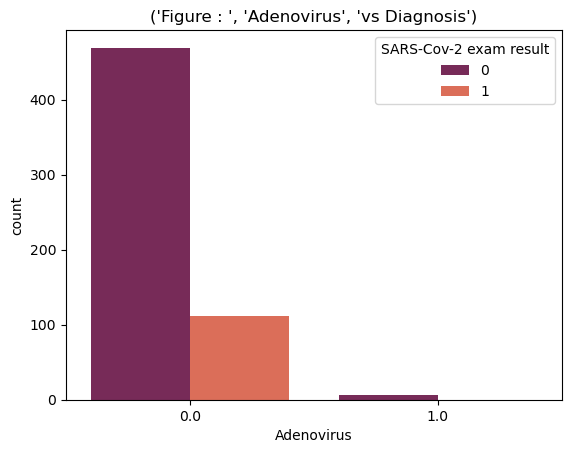

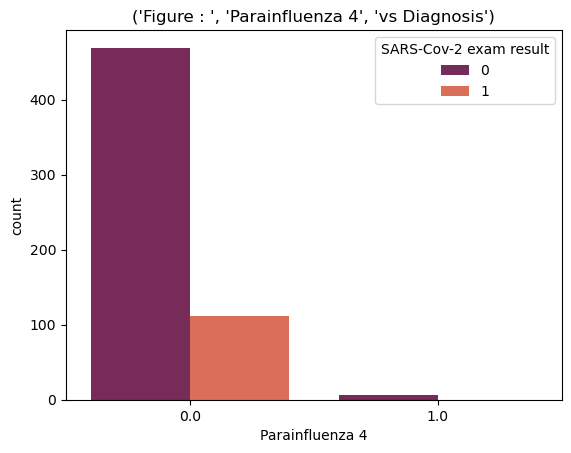

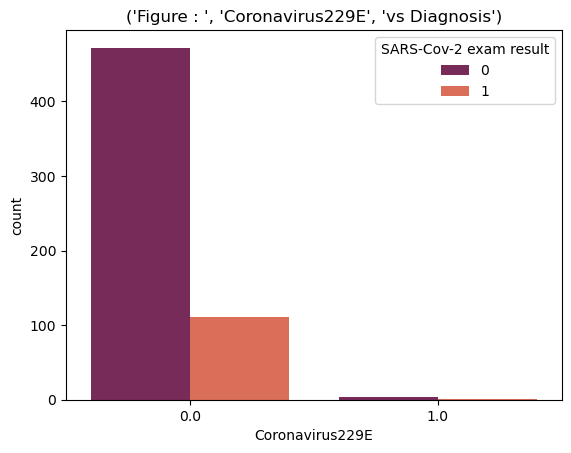

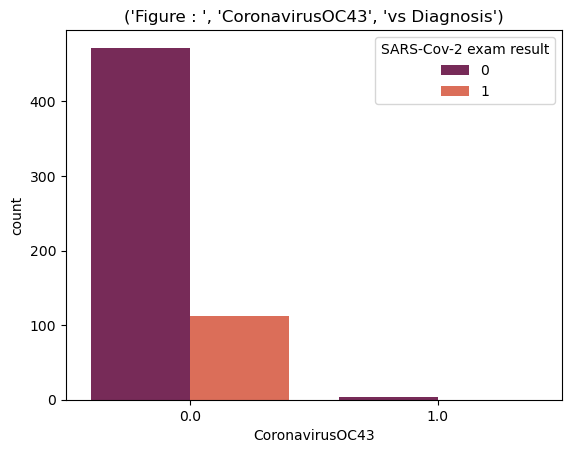

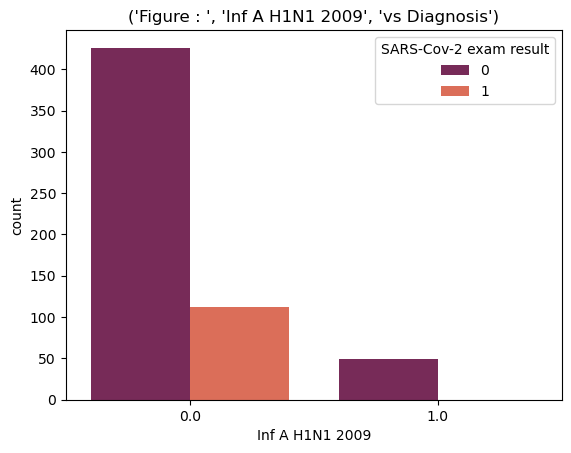

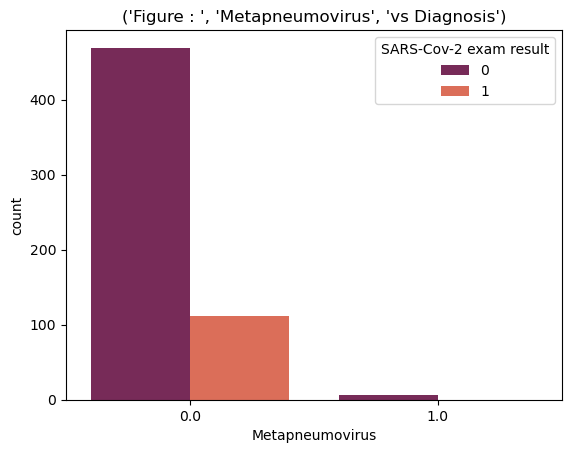

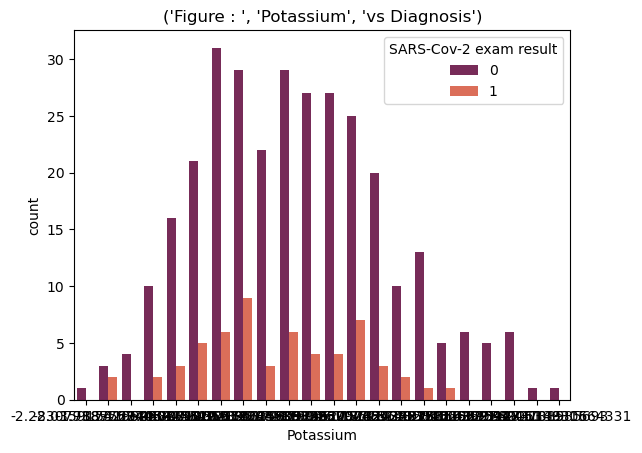

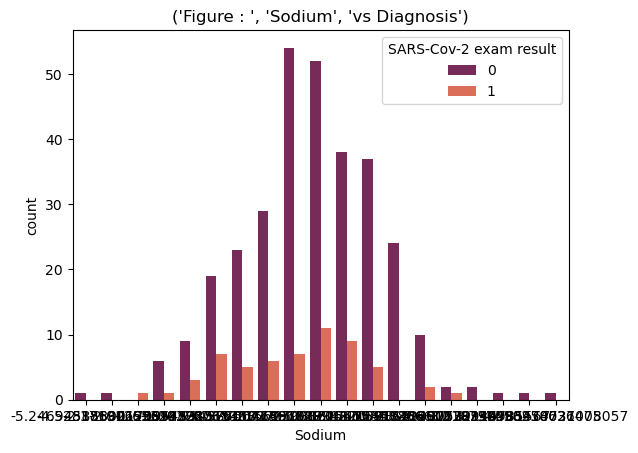

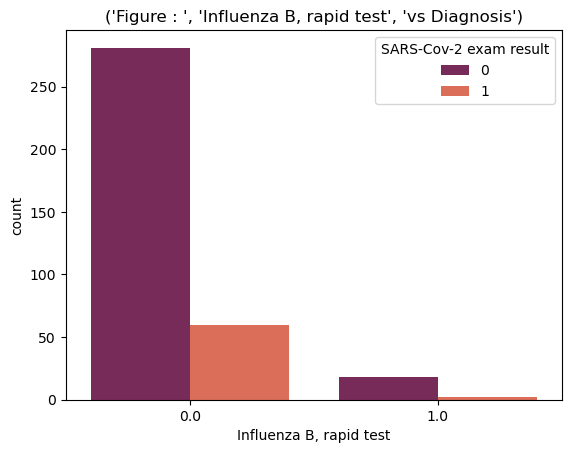

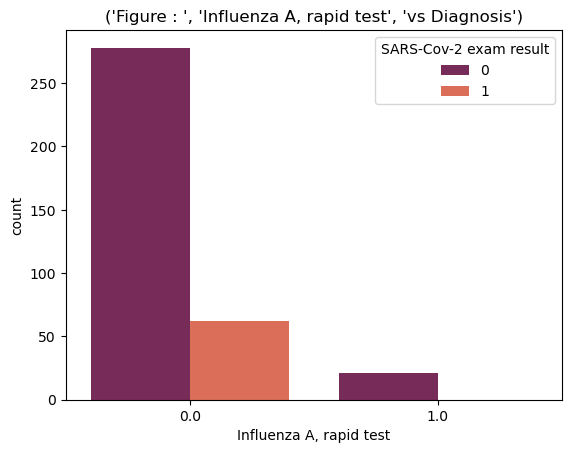

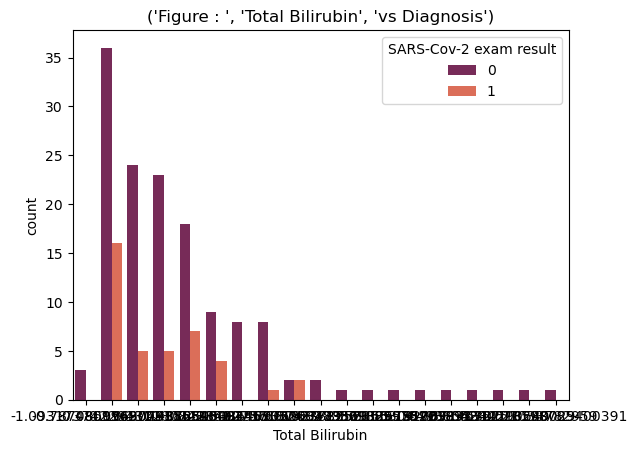

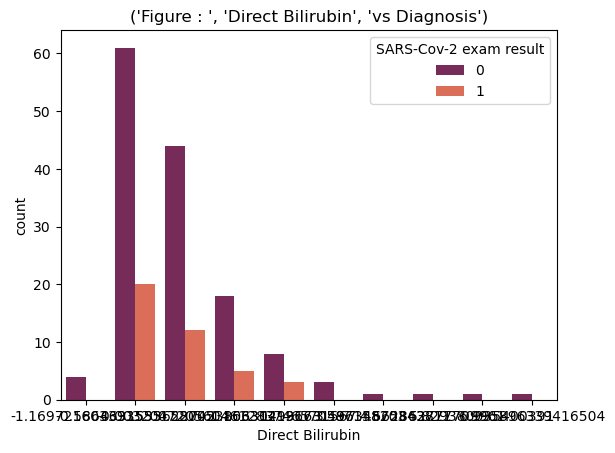

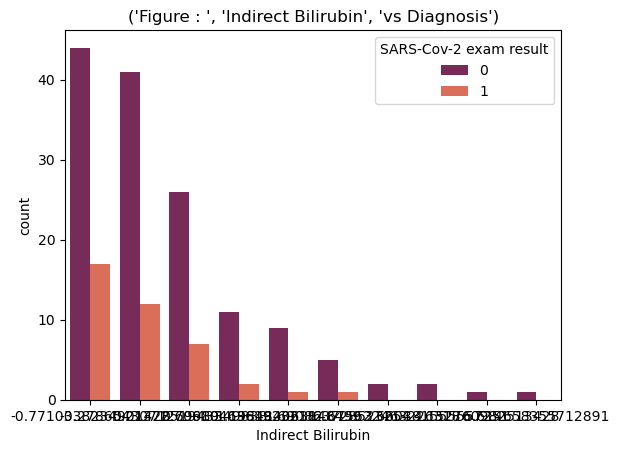

In [56]:
for feature in X.columns:
 if len(X[feature].value_counts()) <= 25 : 
  plt.figure() 
  sns.countplot(x=feature,hue='SARS-Cov-2 exam result', data=X, palette='rocket').set(title=('Figure : ',feature, 'vs Diagnosis'))    

In [57]:
y=X['SARS-Cov-2 exam result']
X=X.drop(columns=['SARS-Cov-2 exam result'])

## The missing values need to be filled in , so I am using the mean values to fill in the nulls

In [58]:
for feature in X.columns :
    mean_val=X[feature].mean()
    X[feature].fillna(value=mean_val, inplace=True)

In [59]:
from sklearn.preprocessing import StandardScaler
X= StandardScaler().fit_transform(X)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [75]:
NN_cls= Sequential(
    [
    Dense(50,activation='relu',name='L1'),
    Dense(25,activation='relu',name='L2'),
    Dense(10,activation='relu',name='L3'),
    Dense(2,activation='linear',name='L4')
    ]
)

NN_cls.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #<-- Note
    optimizer=tf.keras.optimizers.Adam(0.001),
)

NN_cls.fit(
    X_train,y_train,
    epochs=100
)
      
NN_cls.summary()

Epoch 1/100
26/26 [==============================] - 1s 2ms/step - loss: 0.6462
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 0.5508
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 0.5017
Epoch 4/100
26/26 [==============================] - 0s 1ms/step - loss: 0.4607
Epoch 5/100
26/26 [==============================] - 0s 1ms/step - loss: 0.4266
Epoch 6/100
26/26 [==============================] - 0s 2ms/step - loss: 0.3911
Epoch 7/100
26/26 [==============================] - 0s 1ms/step - loss: 0.3520
Epoch 8/100
26/26 [==============================] - 0s 2ms/step - loss: 0.3058
Epoch 9/100
26/26 [==============================] - 0s 2ms/step - loss: 0.2557
Epoch 10/100
26/26 [==============================] - 0s 1ms/step - loss: 0.2130
Epoch 11/100
26/26 [==============================] - 0s 1ms/step - loss: 0.1764
Epoch 12/100
26/26 [==============================] - 0s 1ms/step - loss: 0.1480
Epoch 13/100
26/26 [=================

In [76]:
predictions=NN_cls.predict(X_test)

11/11 [==============================] - 0s 1ms/step


In [77]:
predictions=tf.nn.softmax(predictions).numpy()
predictions.shape

(345, 2)

In [78]:
Y_test=np.array(y_test)
Y_test.shape

(345,)

In [79]:
y_pred=Y_test

In [80]:
for i in range(len(predictions)):
    y_pred[i] = np.argmax(predictions[i])


In [81]:
accuracy_score(y_test, y_pred)*100

91.88405797101449

In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       187
           1       0.90      0.93      0.91       158

    accuracy                           0.92       345
   macro avg       0.92      0.92      0.92       345
weighted avg       0.92      0.92      0.92       345



# Constructing model for balanced dataset and hyperparameter tuning using Grid Search CV

In [56]:
xgb_clsfr = XGBClassifier() #creating a model with no parameters
n_estimators = [100, 300, 500, 700,1000] # creating lists for different values of hyperparameters
subsample = [0.3,0.5, 0.7, 1.0]
max_depth = [2,4,6, 7, 9]
grid = dict(n_estimators=n_estimators, subsample=subsample, max_depth=max_depth) # creating dictionary to store the lists
grid_search = GridSearchCV(estimator=xgb_clsfr, param_grid=grid, n_jobs=-1, cv=10, scoring='roc_auc', error_score=0) # creating grid search object for xgb
grid_result = grid_search.fit(X_train, y_train) # fitting the grid search on the training data
print("Highest ROC AUC is achieved using the parameters : " , ( grid_result.best_params_))

Highest ROC AUC is achieved using the parameters :  {'max_depth': 7, 'n_estimators': 700, 'subsample': 1.0}


In [58]:
# defining a fucntion that will print different evaluation metrics
def eval_scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    print("Accuracy of the model is: ", (accuracy * 100) , "%")
    print("Precision of the model is: ", (precision * 100) , "%")
    print("Recall of the model is: ", (recall * 100) , "%")
    print("AUC value of the model is:", (roc * 100) , "%")

In [59]:
# setting the hyperparameters of the model from the grid search results
xgb_clsfr.n_estimators = grid_result.best_params_['n_estimators']
xgb_clsfr.subsample = grid_result.best_params_['subsample']
xgb_clsfr.max_depth = grid_result.best_params_['max_depth']

In [60]:
xgb_clsfr.fit(X_train, y_train) #fitting the model 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=700, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [61]:
#printing the scores
y_pred = xgb_clsfr.predict(X_test)
eval_scores(y_test, y_pred)

Accuracy of the model is:  94.20289855072464 %
Precision of the model is:  93.67088607594937 %
Recall of the model is:  93.67088607594937 %
AUC value of the model is: 94.16164624653084 %


In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       187
           1       0.94      0.94      0.94       158

    accuracy                           0.94       345
   macro avg       0.94      0.94      0.94       345
weighted avg       0.94      0.94      0.94       345



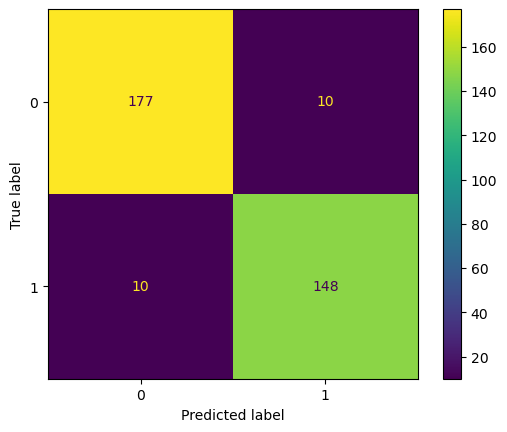

In [63]:
#printing the confusion matrix to analyse how many times a class was correctly and wrongly predicted
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## Plotting the most important features

In [ ]:
importances = xgb_clsfr.get_booster().get_fscore() #obtaining the importance scores for the xgb model and making a database out of them
importances_data = pd.DataFrame({'Feature Importance': list(importances.values()), 'Feature': list(importances.keys())})
importances_data.sort_values(by='Feature Importance', ascending=False, inplace=True) #sorting the importances in a descending order
importances_data = importances_data.head(20) #acessing the top 20 most important features

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
plt.title('20 Most Important Features for the Model', fontsize=14)
sns.barplot(x=importances_data['Feature Importance'], y=importances_data['Feature'])

# Plotting the ROC curve for XGB Model

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
plt.plot([0, 1], [0, 1], '--', color='black')
plt.title('ROC Curve for XGB', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
fpr, tpr, thresholds = roc_curve(y_test, xgb_clsfr.predict_proba(X_test)[:,1]) 
sns.lineplot(x=fpr, y=tpr, linewidth=3 )

# Comparison with Random Forest, Logistic Regression and Decision Tree

In [ ]:
# For each of the RF,LR and DT models, I carried out a grid search to tune hyperparameters, and then evaluated the models based off the same metrics as the XGB Model
rf_clsfr = RandomForestClassifier()

n_estimators = [100, 300, 500, 800, 1000]
max_depth = [5, 8, 15, 25, 30]
grid = dict(n_estimators=n_estimators, max_depth=max_depth)
grid_search = GridSearchCV(estimator=rf_clsfr, param_grid=grid, n_jobs=-1, cv=10, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train, y_train)
print("Best AUC using ", ( grid_result.best_params_))

In [ ]:
rf_clsfr.n_estimators = grid_result.best_params_['n_estimators']
rf_clsfr.max_depth = grid_result.best_params_['max_depth']

In [ ]:
rf_clsfr.fit(X_train, y_train)

In [ ]:
y_pred1 = rf_clsfr.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred1))

In [ ]:
eval_scores(y_test, y_pred1)

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred1)

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
plt.plot([0, 1], [0, 1], '--', color='black')
plt.title('ROC Curve for RF', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
fpr, tpr, thresholds = roc_curve(y_test, rf_clsfr.predict_proba(X_test)[:,1]) 
sns.lineplot(x=fpr, y=tpr, linewidth=3 )

In [ ]:
lr_clsfr = LogisticRegression()

In [ ]:
solver=['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
max_iter = [10, 50, 100, 500]
grid = dict(solver=solver, max_iter=max_iter)
grid_search = GridSearchCV(estimator=lr_clsfr, param_grid=grid, n_jobs=-1, cv=10, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train, y_train)
print("Best AUC using ", ( grid_result.best_params_))

In [ ]:
lr_clsfr.solver = grid_result.best_params_['solver']
lr_clsfr.max_iter = grid_result.best_params_['max_iter']

In [ ]:
lr_clsfr.fit(X_train, y_train)

In [ ]:
y_pred2 = lr_clsfr.predict(X_test)

In [ ]:
eval_scores(y_test, y_pred2)

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
plt.plot([0, 1], [0, 1], '--', color='black')
plt.title('ROC Curve for LR', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
fpr, tpr, thresholds = roc_curve(y_test, lr_clsfr.predict_proba(X_test)[:,1]) 
sns.lineplot(x=fpr, y=tpr, linewidth=3 )

In [ ]:
dt_clsfr = DecisionTreeClassifier()

In [ ]:
criterion =['gini', 'entropy']
splitter=['best', 'random']
max_depth = [5, 8, 15, 25, 30]
grid = dict(criterion=criterion, max_depth=max_depth,splitter=splitter)
grid_search = GridSearchCV(estimator=dt_clsfr, param_grid=grid, n_jobs=-1, cv=10, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train, y_train)
print("Best AUC using ", ( grid_result.best_params_))

In [ ]:
dt_clsfr.criterion = grid_result.best_params_['criterion']
dt_clsfr.max_depth = grid_result.best_params_['max_depth']
dt_clsfr.splitter = grid_result.best_params_['splitter']
dt_clsfr.fit(X_train, y_train)
y_pred3 = dt_clsfr.predict(X_test)
eval_scores(y_test, y_pred3)
print(classification_report(y_test, y_pred3))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred3)

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
plt.plot([0, 1], [0, 1], '--', color='black')
plt.title('ROC Curve for DT', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
fpr, tpr, thresholds = roc_curve(y_test, dt_clsfr.predict_proba(X_test)[:,1]) 
sns.lineplot(x=fpr, y=tpr, linewidth=3 )